In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import holidays

from neuralprophet import NeuralProphet
from prophet import Prophet
from prophet.serialize import model_to_json
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

# Количество предсказанных дней
pred_days_forecast = 365

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
# Чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# Чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# Чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [3]:
# Преобразование столбца ds в формат datetime
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

# Baseline Prophet on df_train для проверки модели

In [4]:
# Обучение модели на train
model_baseline = Prophet()
model_baseline.fit(df_train)

02:19:45 - cmdstanpy - INFO - Chain [1] start processing
02:19:45 - cmdstanpy - INFO - Chain [1] done processing


In [5]:
# Период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [6]:
# Создание df с прогнозом
future = model_baseline.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_baseline.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2662,2024-01-29,10.309328,8.684935,11.937042
2663,2024-01-30,10.327363,8.782221,11.830642
2664,2024-01-31,10.365041,8.776355,11.879173
2665,2024-02-01,10.367720,8.784294,11.983866
2666,2024-02-02,10.368388,8.900761,12.037758


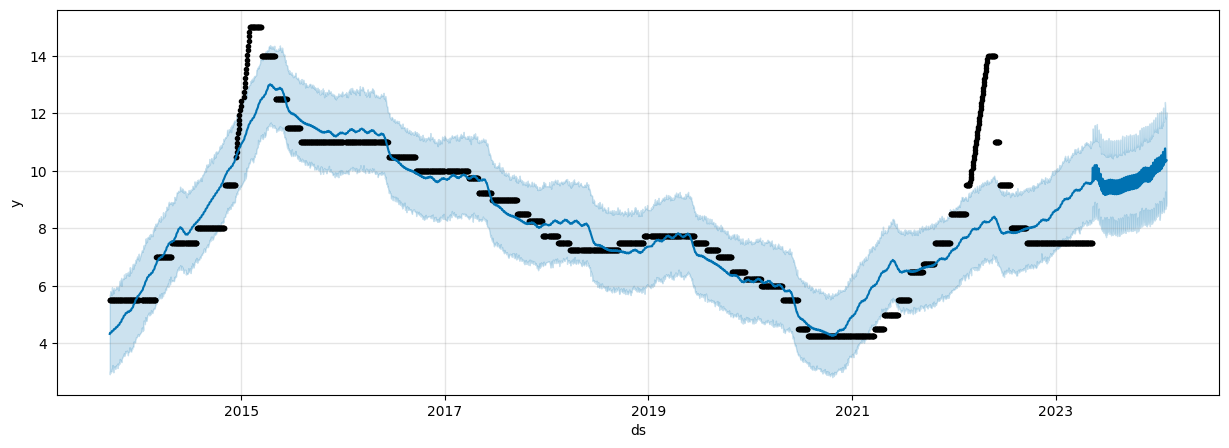

In [7]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_baseline.plot(forecast,ax=ax)
plt.show()

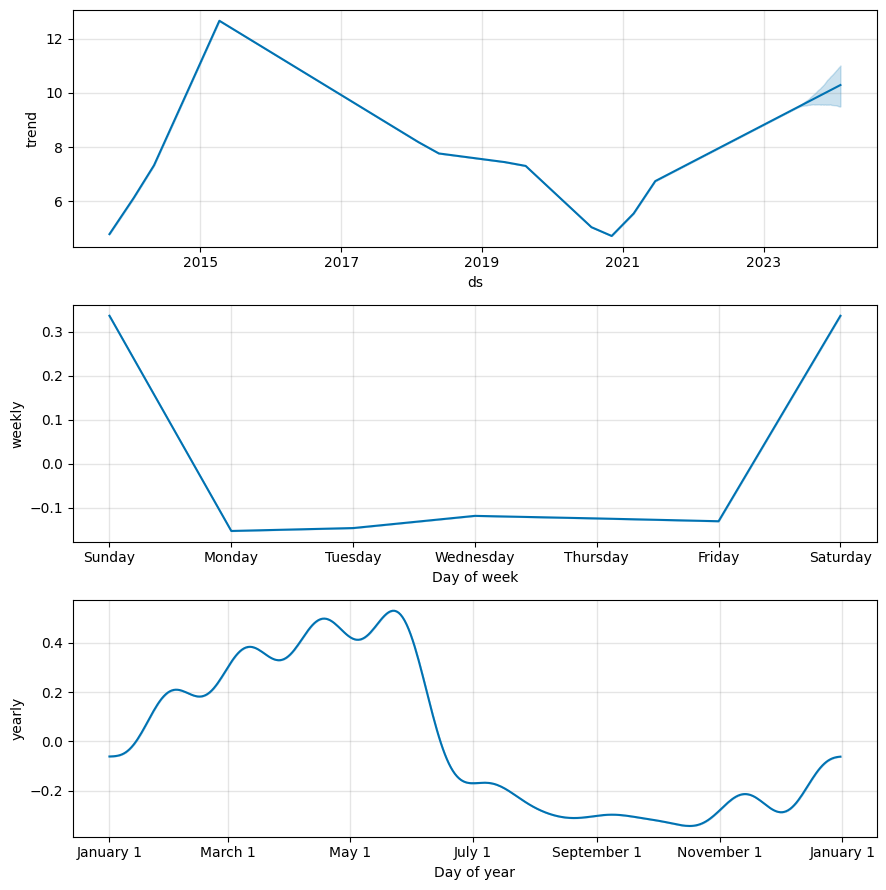

In [8]:
# Смотрим тренд, годовые и сезонные признаки
fig = model_baseline.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [9]:
# Создание df с прогнозом
df_test_forecast = model_baseline.predict(df_test)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2024-05-23,11.107721,9.217851,12.957801
262,2024-05-24,11.101794,9.132474,13.016723
263,2024-05-27,11.064885,9.247023,13.074009
264,2024-05-28,11.061010,9.204593,13.073939
265,2024-05-29,11.075536,9.181557,12.973968


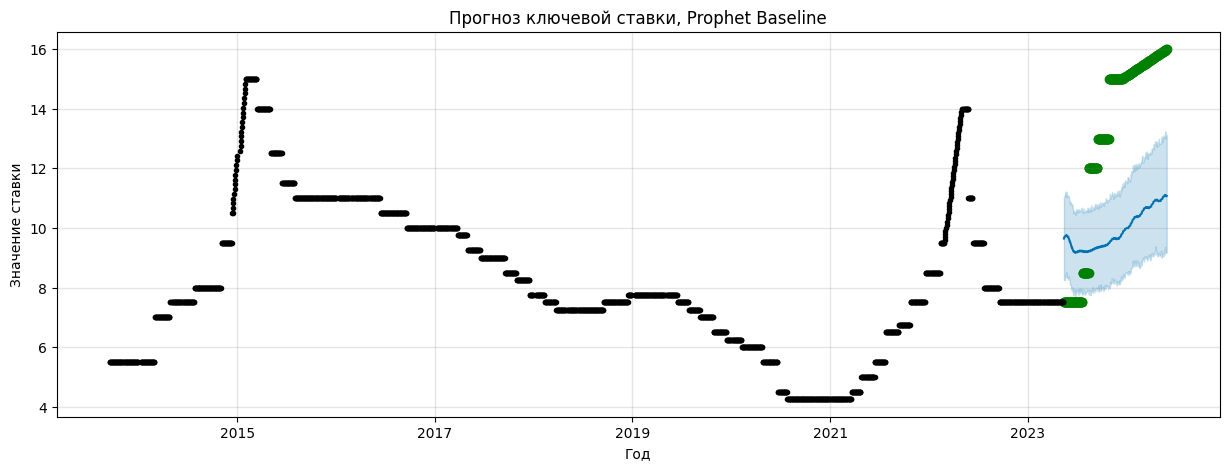

In [10]:
# Смотрим совпадение фактического курса с предсказанным курсом prophet baseline обученным на train
fig, ax = plt.subplots(figsize= (10, 5))

fig.set_figheight(5)
fig.set_figwidth(15)
predict = model_baseline.predict(df_test)
fig = model_baseline.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet Baseline')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

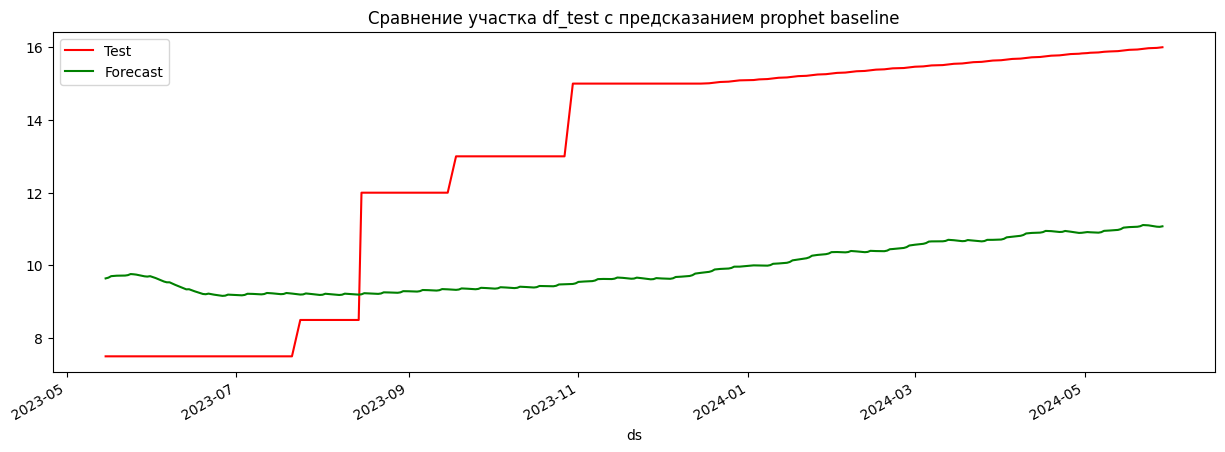

In [11]:
# Сравнение участка df_test с предсказанием prophet baseline
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet baseline')
plt.show()

In [12]:
# Просмотр метрик модели обученной на train
metrics = get_metrics(y_test=df_test['y'], y_pred=df_test_forecast['yhat'], name='Prophet_baseline')
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.832909,0.284886,16.925644,4.114079


Из приведенного выше графика мы видим, что существует разрыв в прогнозах и фактических данных. Поэтому нам нужно оптимизировать модель, добавив другие параметры, напрмиер, такие как праздники

# Prophet with holidays

In [13]:
# Создаем df праздников в РФ начиная с 2013 по сегодня
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)  

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [14]:
# Тренировка модели с праздниками
model_with_holidays = Prophet(holidays=holiday)
model_with_holidays.fit(df_train)

02:19:49 - cmdstanpy - INFO - Chain [1] start processing
02:19:49 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
# Создание df с прогнозом
future = model_with_holidays.make_future_dataframe(periods=pred_days, freq='D')
forecast = model_with_holidays.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2662,2024-01-29,10.335182,8.767984,11.745331
2663,2024-01-30,10.352825,8.735439,11.944702
2664,2024-01-31,10.391619,8.710150,11.934068
2665,2024-02-01,10.393611,8.791795,11.978862
2666,2024-02-02,10.396470,8.774100,11.906122


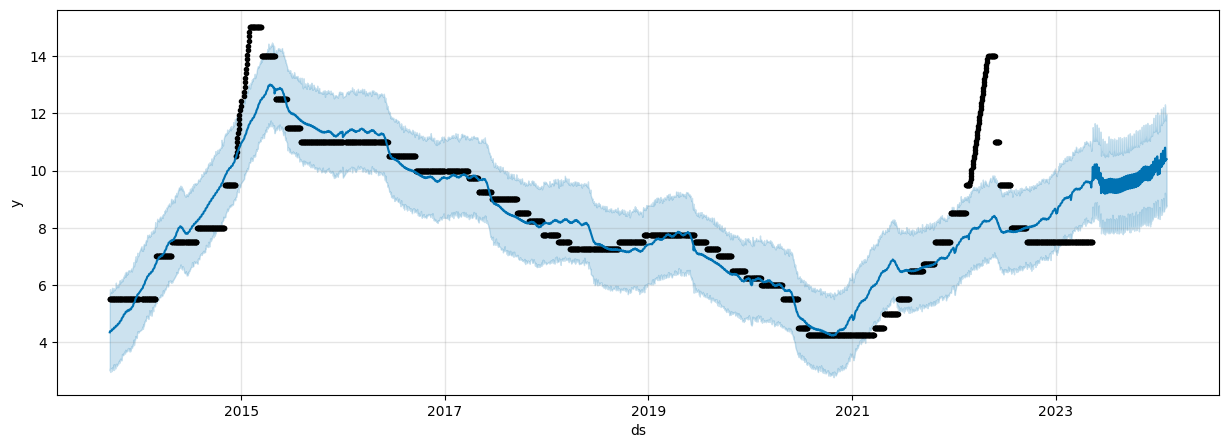

In [16]:
# Смотрим график прогноза с праздниками
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = model_with_holidays.plot(forecast,ax=ax)
plt.show()

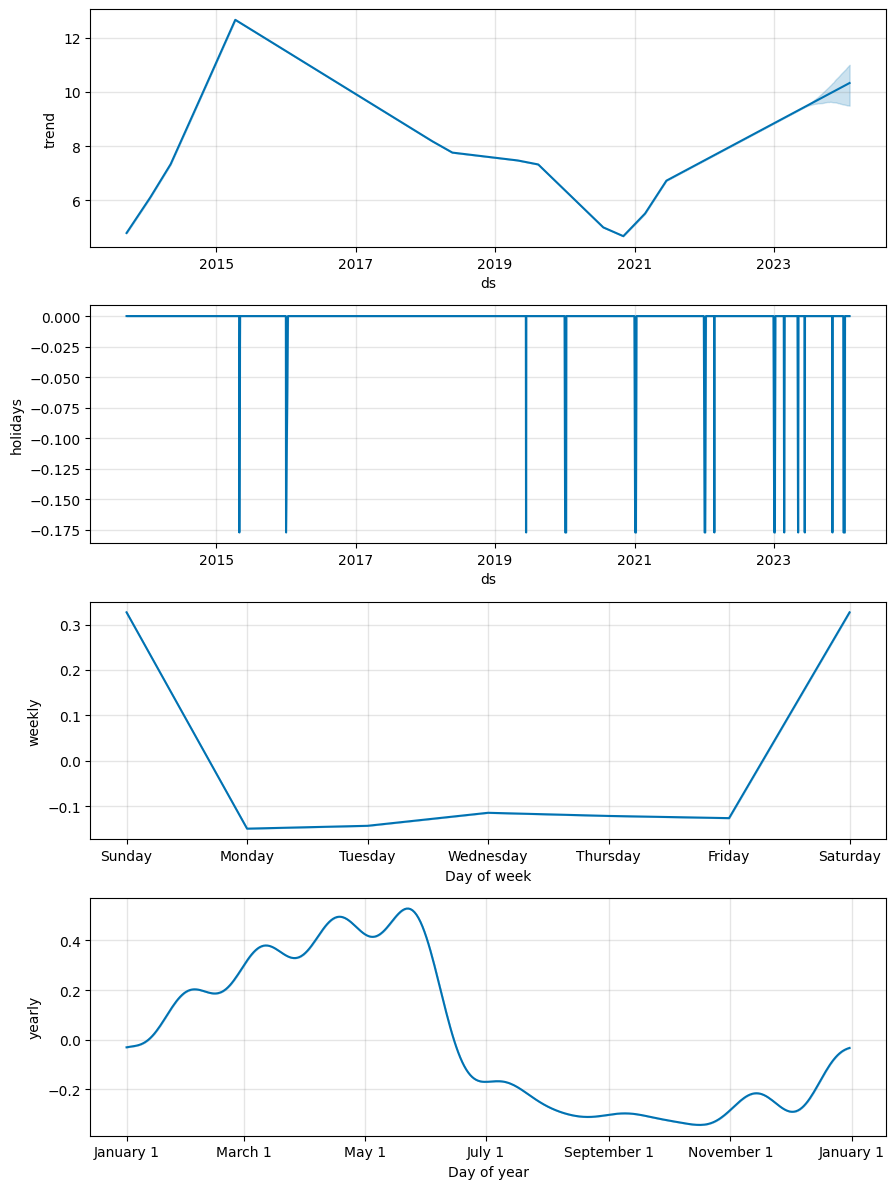

In [17]:
# Смотрим тренд, годовые и сезонные признаки обученной модели с праздниками
fig = model_with_holidays.plot_components(forecast)
plt.show()

## Сравнение фактов и прогнозов

In [18]:
# Создание df с прогнозом
df_test_forecast_holiday = model_with_holidays.predict(df_test)
df_test_forecast_holiday[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2024-05-23,11.147314,9.165481,12.968654
262,2024-05-24,11.143227,9.123824,12.952439
263,2024-05-27,11.106260,9.011528,13.028176
264,2024-05-28,11.102439,8.960387,12.856776
265,2024-05-29,11.118250,8.991492,12.992065


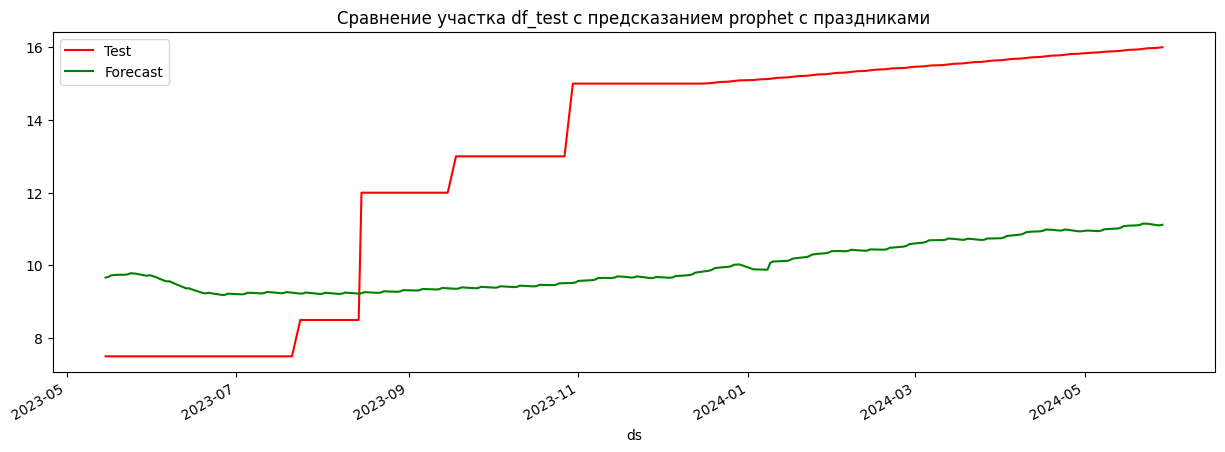

In [19]:
# Сравнение участка df_test с предсказанием prophet_with_holidays
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_holiday.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet с праздниками')
plt.show()

In [20]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_holiday['yhat'], name='Prophet_with_holidays')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.832909,0.284886,16.925644,4.114079
0,Prophet_with_holidays,3.815387,0.284071,16.728433,4.090041


Из метрик и графиков видим, что модель с праздниками показывает результаты немного изменились.

# Тюнинг тест модели

In [21]:
# Создание сетки параметров и подсчёт количества вариаций обучения
params_grid = {
    'changepoint_prior_scale': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.3, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1, 10], 
    'holidays_prior_scale': [0.01, 0.1, 1, 10],
    'seasonality_mode': ('multiplicative','additive')
}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt + 1

print('Количество моделей для обучения по сетке:', cnt)

Количество моделей для обучения по сетке: 672


In [22]:
"""Обучение тестовой модели по сетке параметров на df_train"""
# Создаем пустой DataFrame для сохранения метрик и параметров
model_grid_metrics = pd.DataFrame()
model_grid_parameters = pd.DataFrame(columns = ['Parameters'])

# Проходимся по сетке гиперпараметров
for p in tqdm(grid):
    
    # Обучаем Prophet по сетке гиперпараметров
    model_grid = Prophet(
        changepoint_prior_scale = p['changepoint_prior_scale'],
        seasonality_prior_scale = p['seasonality_prior_scale'],
        holidays_prior_scale = p['holidays_prior_scale'],
        seasonality_mode = p['seasonality_mode'],
        #changepoint_range = p['changepoint_range'],
        #holidays=holiday,
    )

    # Добавляем праздники в модель
    #model_grid.add_country_holidays(country_name='RU')

    # Обучаем модель
    model_grid.fit(df_train)

    # Создаем фрейм данных для предсказаний
    model_grid_future = model_grid.make_future_dataframe(periods=pred_days, freq='D', include_history=False)

    # Делаем предсказания
    model_grid_forecast = model_grid.predict(model_grid_future)

    # Вычисляем метрики и добавляем новую строку в df
    model_grid_metrics = pd.concat([model_grid_metrics, get_metrics(y_test=df_test['y'], y_pred=model_grid_forecast['yhat'], name='Prophet_with_grid ')])
    model_grid_parameters = pd.concat([model_grid_parameters, pd.DataFrame({'Parameters': [p]})], ignore_index=True)


  0%|          | 0/672 [00:00<?, ?it/s]02:19:52 - cmdstanpy - INFO - Chain [1] start processing
02:19:52 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/672 [00:00<07:15,  1.54it/s]02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 2/672 [00:01<07:03,  1.58it/s]02:19:53 - cmdstanpy - INFO - Chain [1] start processing
02:19:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 3/672 [00:01<07:02,  1.58it/s]02:19:54 - cmdstanpy - INFO - Chain [1] start processing
02:19:54 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 4/672 [00:02<07:04,  1.57it/s]02:19:54 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 5/672 [00:03<07:03,  1.57it/s]02:19:55 - cmdstanpy - INFO - Chain [1] start processing
02:19:55 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 6/672 [00:03<06:49,  1.63it/s]0

In [23]:
# Сброс индексов для будущего объединения с df параметров сетки
model_grid_metrics = model_grid_metrics.reset_index(drop=True)

In [24]:
# Объединение DataFrame по столбцам
metrics_parameters_with_grid = pd.concat([model_grid_metrics, model_grid_parameters], axis=1)
metrics_parameters_with_grid

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,6.509059,0.456008,53.674969,7.326320,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
1,Prophet_with_grid,6.634304,0.464238,55.988693,7.482559,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
2,Prophet_with_grid,6.901529,0.486110,59.758432,7.730358,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
3,Prophet_with_grid,6.715970,0.470894,57.139508,7.559068,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
4,Prophet_with_grid,6.370853,0.443554,52.254716,7.228742,"{'changepoint_prior_scale': 0.001, 'holidays_p..."
...,...,...,...,...,...,...
667,Prophet_with_grid,12.188552,0.949488,275.279321,16.591544,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
668,Prophet_with_grid,4.769872,0.338903,28.465055,5.335265,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
669,Prophet_with_grid,4.798784,0.340962,28.792869,5.365899,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."
670,Prophet_with_grid,4.841914,0.343358,29.394691,5.421687,"{'changepoint_prior_scale': 0.5, 'holidays_pri..."


In [25]:
# Сортировка по метрике
metrics_parameters_with_grid = metrics_parameters_with_grid.sort_values(by=['MAE'])
metrics_parameters_with_grid = metrics_parameters_with_grid.reset_index(drop=True)
metrics_parameters_with_grid.head()

,model,MAE,MAPE_%,MSE,RMSE,Parameters
0,Prophet_with_grid,3.869808,0.295130,16.816118,4.100746,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
1,Prophet_with_grid,3.869808,0.295130,16.816118,4.100746,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
2,Prophet_with_grid,3.869808,0.295130,16.816118,4.100746,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
3,Prophet_with_grid,3.869808,0.295130,16.816118,4.100746,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."
4,Prophet_with_grid,3.884292,0.295991,16.965895,4.118968,"{'changepoint_prior_scale': 0.03, 'holidays_pr..."


## Лучшие параметры после обучения по сетке

In [26]:
# Сохранение в переменную лучших параметров после обучения по сетке
best_params = metrics_parameters_with_grid['Parameters'][0]

# Просмотр лучших параметров
best_params

{'changepoint_prior_scale': 0.03,
 'holidays_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 1}

In [27]:
# Обучение модели на лучших параметрах
final_test_model = Prophet(**best_params)
final_test_model.fit(df_train)

02:39:08 - cmdstanpy - INFO - Chain [1] start processing
02:39:09 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
# Создание df с прогнозом
future = final_test_model.make_future_dataframe(periods=pred_days, freq='D')
forecast = final_test_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2662,2024-01-29,10.866426,9.329746,12.350322
2663,2024-01-30,10.887843,9.334982,12.467539
2664,2024-01-31,10.928998,9.384175,12.336966
2665,2024-02-01,10.929894,9.433240,12.558177
2666,2024-02-02,10.932024,9.370515,12.458046


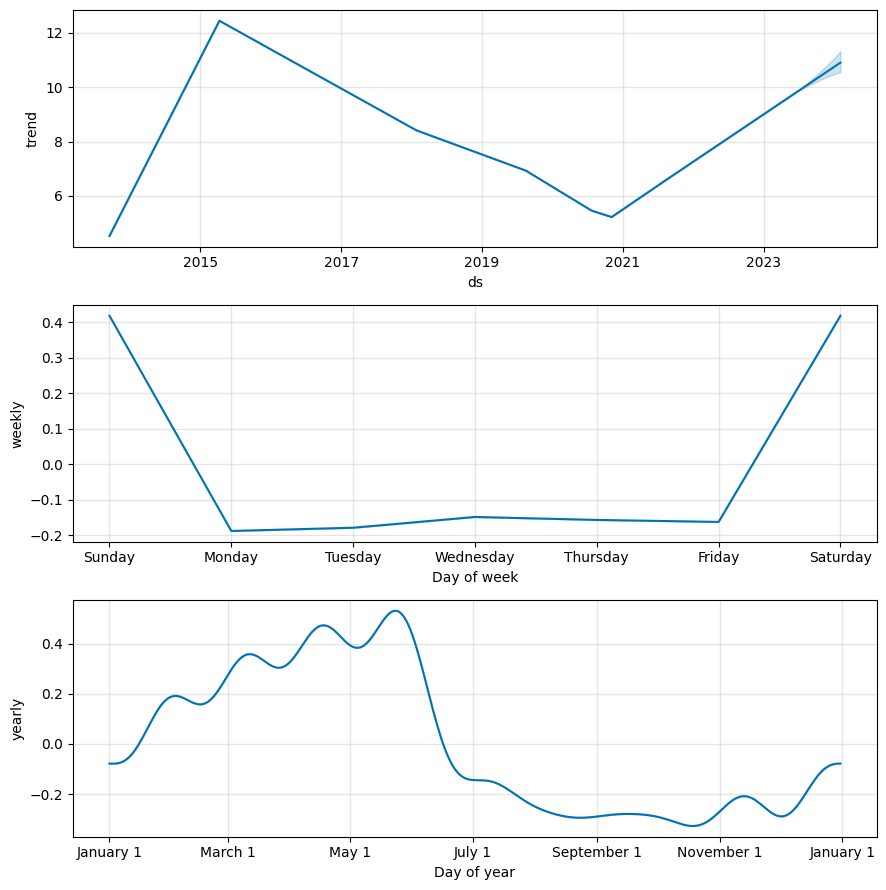

In [29]:
# Смотрим тренд, годовые и сезонные признаки
fig = final_test_model.plot_components(forecast)

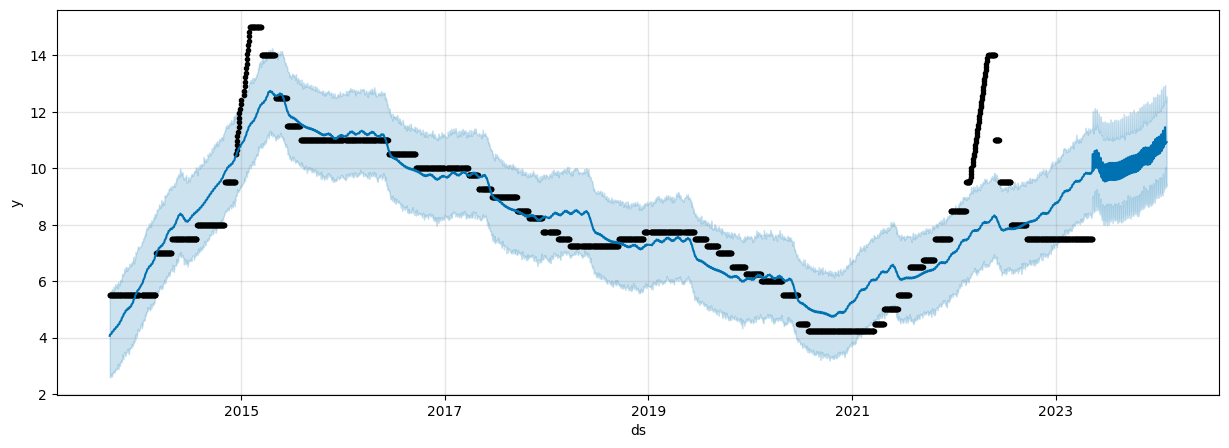

In [30]:
# Смотрим график прогноза после обучния на лучших параметрах
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast,ax=ax)
plt.show()

## Сравнение фактов и прогнозов

In [31]:
# Создание df с прогнозом
df_test_forecast_final = final_test_model.predict(df_test)
df_test_forecast_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
261,2024-05-23,11.809571,10.174487,13.423856
262,2024-05-24,11.807843,10.196003,13.469194
263,2024-05-27,11.777593,10.203596,13.378035
264,2024-05-28,11.779496,10.254496,13.482179
265,2024-05-29,11.799876,10.178854,13.445689


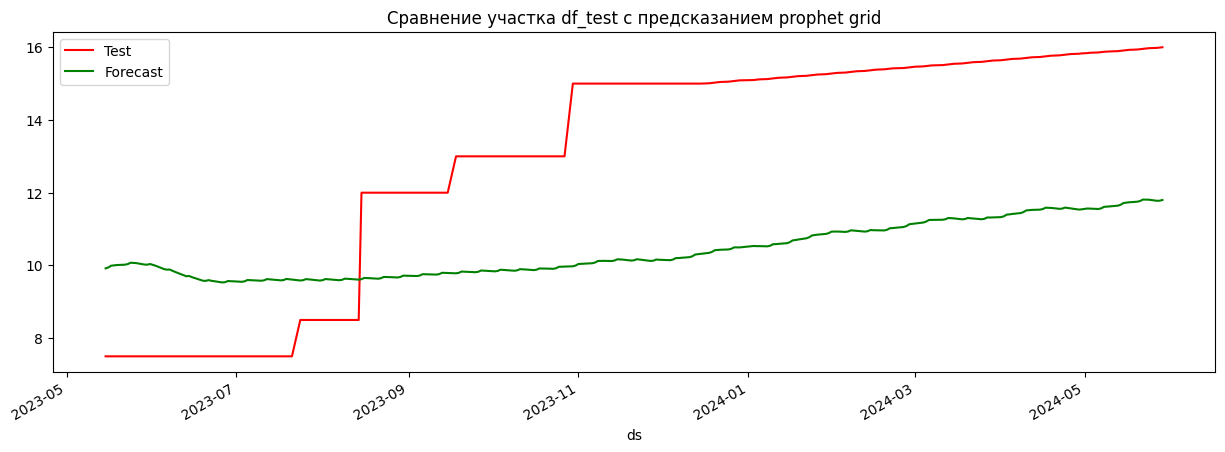

In [32]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
df_test_forecast_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием prophet grid')
plt.show()

In [33]:
# Сравниваем метрики после добавления в модель праздников 
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=df_test_forecast_final['yhat'], name='Prophet_with_grid')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.832909,0.284886,16.925644,4.114079
0,Prophet_with_holidays,3.815387,0.284071,16.728433,4.090041
0,Prophet_with_grid,3.510748,0.268330,13.662536,3.696287


In [54]:
# Сохранение модели в JSON файл
with open('../models/final_test_model.json', 'w') as fout:
    fout.write(model_to_json(final_test_model))

# Baseline NeuralProphet on df_train для проверки модели

In [35]:
# Обучение модели на df
NeuralProphet_bl = NeuralProphet()
NeuralProphet_bl.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_bl.fit(df_train)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.126% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 90
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (38) is too small than the required number                     for the learning rate finder (234). The results might not be optimal.


Finding best initial lr:   0%|          | 0/234 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [36]:
# Создание df с прогнозом
future_np_bl = NeuralProphet_bl.make_future_dataframe(df_train, periods = pred_days, n_historic_predictions = True)
forecast_np_bl = NeuralProphet_bl.predict(df_test)
forecast_np_bl.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.126% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.368% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.368% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


Predicting: 38it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
261,2024-05-23,15.964286,11.547159,18.413090,0.361074,-7.227005
262,2024-05-24,15.973214,11.588501,18.418047,0.366638,-7.196185
263,2024-05-27,15.982143,11.584669,18.432919,0.378826,-7.227075
264,2024-05-28,15.991071,11.592182,18.437874,0.381266,-7.226958
265,2024-05-29,16.000000,11.626421,18.442831,0.382845,-7.199255


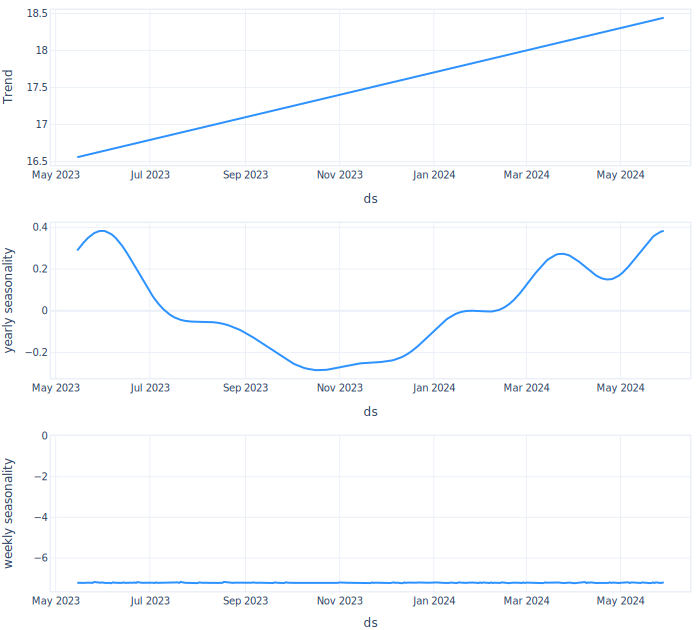

In [37]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_bl.plot_components(forecast_np_bl)

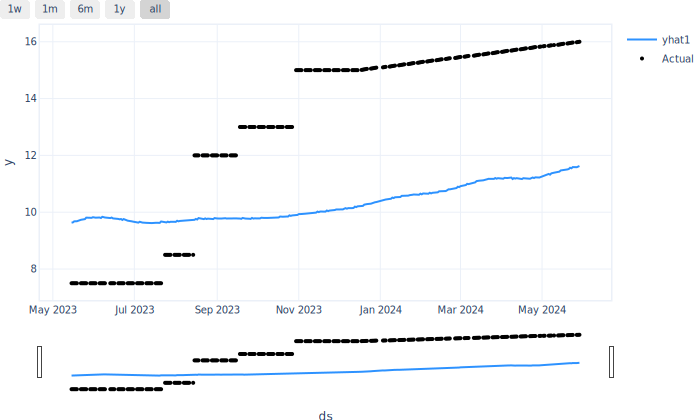

In [38]:
# Смотрим график прогноза после обучения
fig = NeuralProphet_bl.plot(forecast_np_bl, ax=ax)

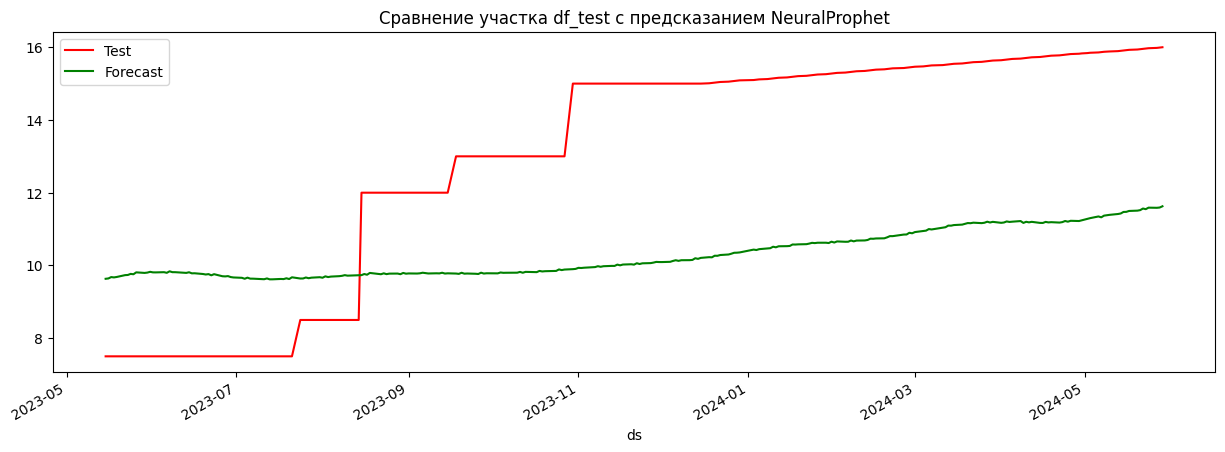

In [39]:
# Сравнение участка df_test с предсказанием prophet grid
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df_test.plot(kind='line',x='ds', y='y', color='red', label='Test', ax=ax)
forecast_np_bl.plot(kind='line',x='ds',y='yhat1', color='green',label='Forecast', ax=ax)
plt.title('Сравнение участка df_test с предсказанием NeuralProphet')
plt.show()

In [40]:
# Сравниваем метрики после добавления NeuralProphet
metrics = pd.concat([metrics, get_metrics(y_test=df_test['y'], y_pred=forecast_np_bl['yhat1'], name='NeuralProphet')])
metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Prophet_baseline,3.832909,0.284886,16.925644,4.114079
0,Prophet_with_holidays,3.815387,0.284071,16.728433,4.090041
0,Prophet_with_grid,3.510748,0.268330,13.662536,3.696287
0,NeuralProphet,3.614105,0.274767,14.593004,3.820079


# Обучение и прогнозирование курса ставки рефинансирования ЦБ РФ на df

# Prophet baseline on df

In [41]:
# Обучение модели на df
prophet_bl = Prophet()
prophet_bl.fit(df)

02:39:58 - cmdstanpy - INFO - Chain [1] start processing
02:39:58 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
# Создание df с прогнозом
future_bl = prophet_bl.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_bl = prophet_bl.predict(future_bl)
forecast_bl[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3027,2025-05-25,17.821542,15.766616,19.893727
3028,2025-05-26,17.000237,15.087145,18.881668
3029,2025-05-27,16.995043,14.903279,18.860611
3030,2025-05-28,17.004940,14.937492,18.981620
3031,2025-05-29,16.979179,14.909100,18.942257


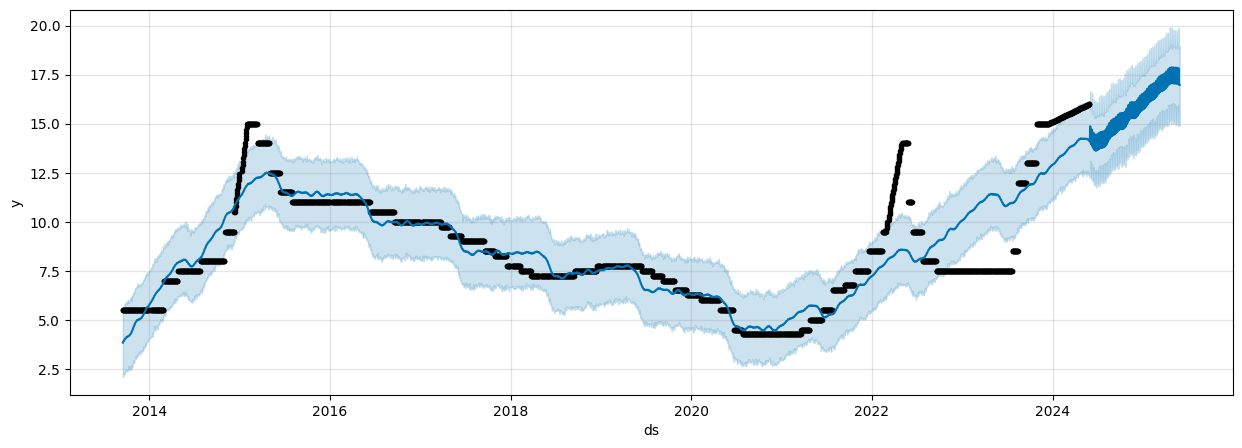

In [43]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = prophet_bl.plot(forecast_bl,ax=ax)
plt.show()

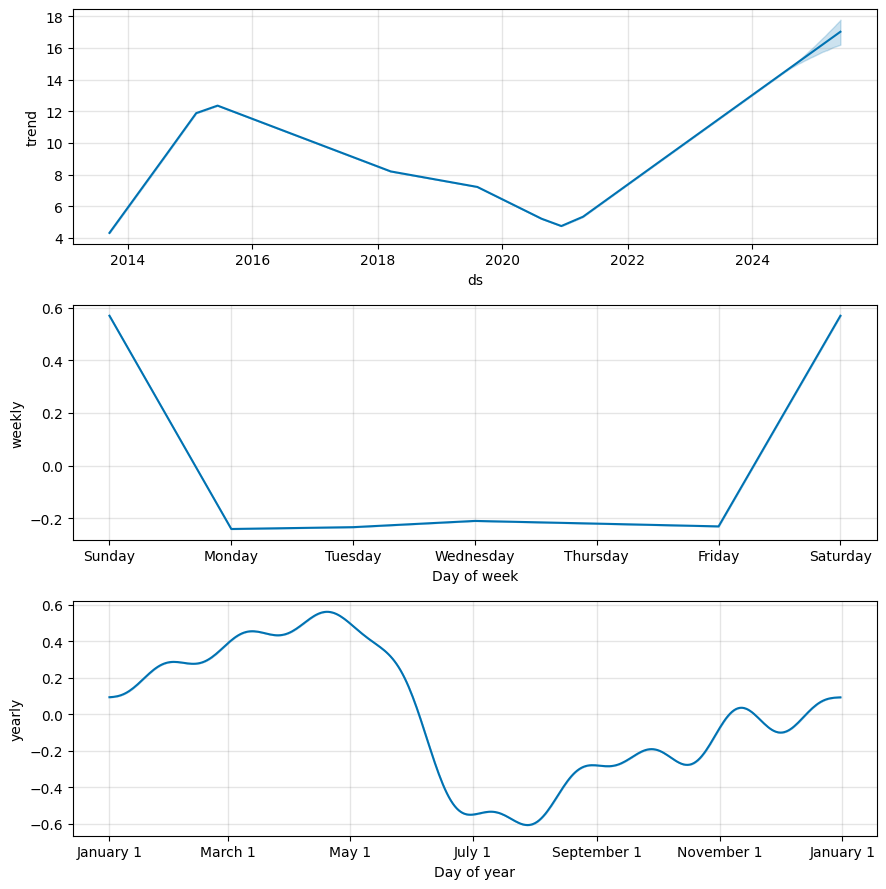

In [44]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_bl)
plt.show()

# Prophet best params on df

In [45]:
# Обучение модели на df
final_test_model = Prophet()
final_test_model.fit(df)

02:40:01 - cmdstanpy - INFO - Chain [1] start processing
02:40:03 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
# Создание df с прогнозом
future_ftm = final_test_model.make_future_dataframe(periods=pred_days_forecast, freq='D')
forecast_ftm = final_test_model.predict(future_ftm)
forecast_ftm[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3027,2025-05-25,17.821542,16.022003,19.787839
3028,2025-05-26,17.000237,15.081555,19.093058
3029,2025-05-27,16.995043,15.082676,19.054882
3030,2025-05-28,17.004940,15.133310,18.818487
3031,2025-05-29,16.979179,14.924008,18.972481


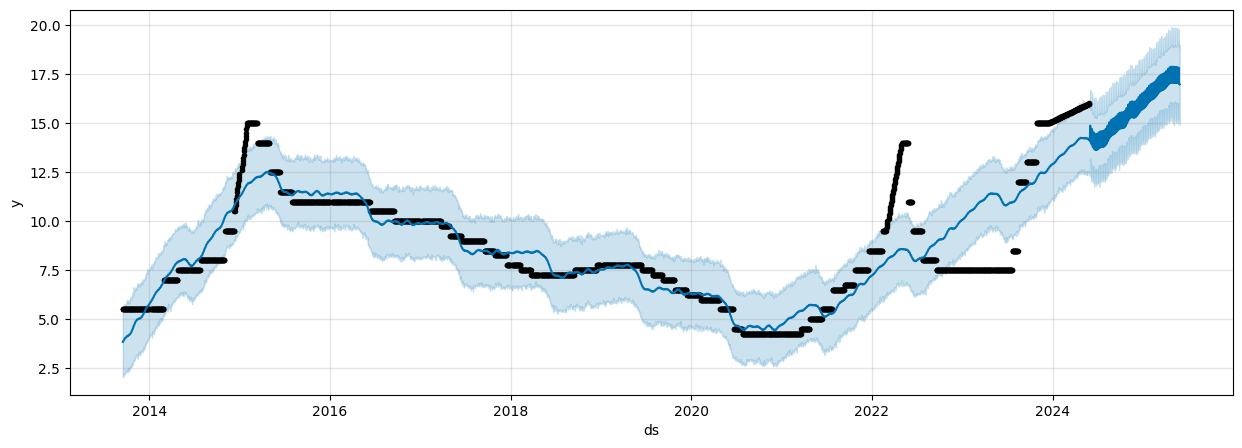

In [47]:
# Смотрим график прогноза
fig, ax = plt.subplots(1)
fig.set_figheight(5)
fig.set_figwidth(15)
fig = final_test_model.plot(forecast_ftm,ax=ax)
plt.show()

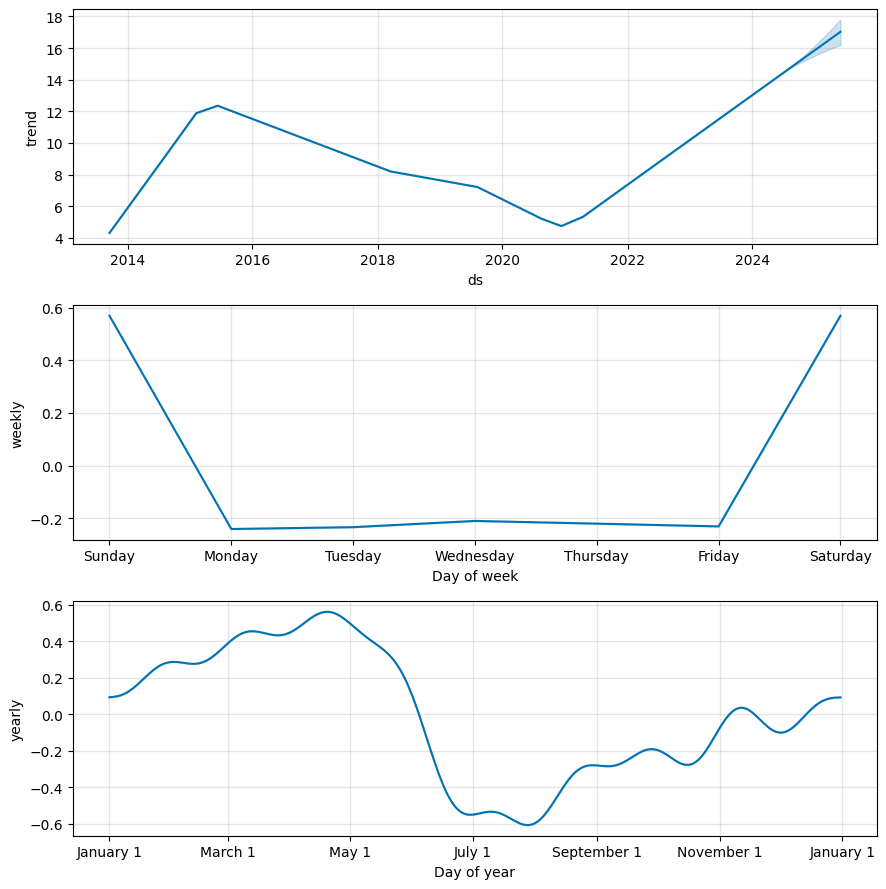

In [48]:
# Смотрим тренд, годовые и сезонные признаки
fig = prophet_bl.plot_components(forecast_ftm)
plt.show()

# NeuralProphet on df

In [49]:
# Обучение модели на df
NeuralProphet_df = NeuralProphet()
NeuralProphet_df.set_plotting_backend("plotly-static")
metricsnp = NeuralProphet_df.fit(df,)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.188% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 64
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 80
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (42) is too small than the required number                     for the learning rate finder (236). The results might not be optimal.


Finding best initial lr:   0%|          | 0/236 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [50]:
# Создание df с прогнозом
future_np = NeuralProphet_df.make_future_dataframe(df, periods = pred_days_forecast-104, n_historic_predictions = True)
forecast_np = NeuralProphet_df.predict(future_np)
forecast_np.tail()

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.188% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.439% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 97.439% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.data.processing._handle_missing_data) - Dropped 261 rows at the end with NaNs in 'y' column.


Predicting: 42it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly,season_weekly
2923,2025-05-23,NaN,17.266262,15.221693,0.270447,1.774121
2924,2025-05-26,NaN,17.236639,15.245816,0.221679,1.769143
2925,2025-05-27,NaN,17.237804,15.253856,0.204141,1.779806
2926,2025-05-28,NaN,17.247768,15.261899,0.186012,1.799856
2927,2025-05-29,NaN,17.222931,15.269939,0.167365,1.785628


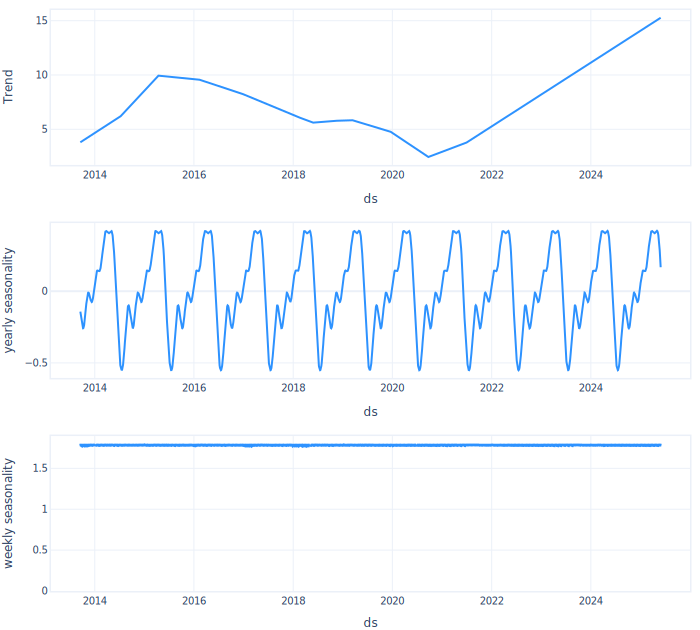

In [51]:
# Смотрим тренд, годовые и сезонные признаки
NeuralProphet_df.plot_components(forecast_np)

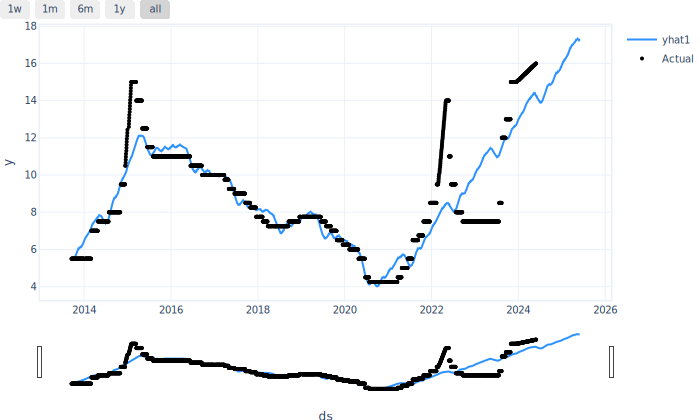

In [52]:
# Смотрим график прогноза
NeuralProphet_df.plot(forecast_np)

# Сравнение прогнозов обученных моделей

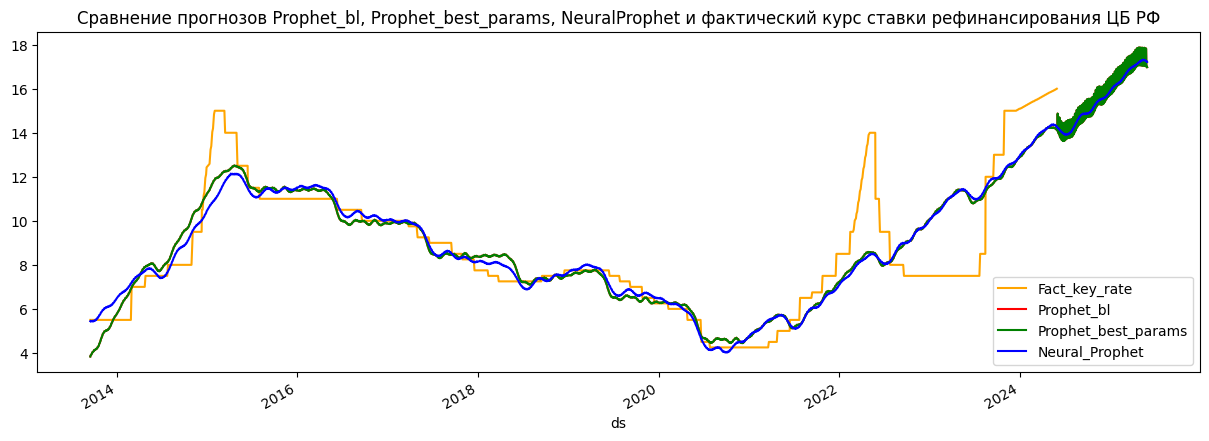

In [53]:
# Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ
fig, ax = plt.subplots(figsize=(14,5))
fig.set_figheight(5)
fig.set_figwidth(15)
df.plot(kind='line',x='ds', y='y', color='orange', label='Fact_key_rate', ax=ax)
forecast_bl.plot(kind='line', x='ds', y='yhat', color='red', label='Prophet_bl', ax=ax)
forecast_ftm.plot(kind='line', x='ds', y='yhat', color='green', label='Prophet_best_params', ax=ax)
forecast_np.plot(kind='line', x='ds', y='yhat1', color='blue', label='Neural_Prophet', ax=ax)
plt.title('Сравнение прогнозов Prophet_bl, Prophet_best_params, NeuralProphet и фактический курс ставки рефинансирования ЦБ РФ')
plt.show()

Исходя из графиков, видно что Prophet с лучшими параметрами, лучше предсказал курс ключевой ставки ЦБ РФ.